# Applying Categorical Machine Learning Techniques

In [1]:
import itertools
import pandas as pd
import numpy as np
from financial_data import *
from misc import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt

from dataclasses import dataclass

from sklearn import svm
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import graphviz
%matplotlib inline

from sklearn.model_selection import GridSearchCV

In [2]:
#plt.style.use('fivethirtyeight')
combined = load_combined()

In [3]:
combined.head()

,loan_id,account_id,loan_date,loan_amount,duration,payments,status,district_id,frequency,account_date,...,no_of_municipalities_with_inhabitants_between_1000_to_9999,no_of_municipalities_with_inhabitants_greater_than_10000,no_of_cities,ratio_of_urban_inhabitants,average_salary,unemployment_rate_95,unemployment_rate_96,no_of_enterpreneurs_per_1000_inhabitants,no_of_commited_crimes_95,no_of_commited_crimes_96
0,4959,2,1994-01-05,0.129680,0.25,0.319488,A,1,monthly,1993-02-26,...,0.00,0.2,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
1,4961,19,1996-04-29,0.043179,0.00,0.231001,B,21,monthly,1995-04-07,...,0.35,0.2,0.6,0.500756,0.224329,0.183099,0.182832,0.488372,0.017452,0.014926
2,4962,25,1997-12-08,0.043179,0.00,0.231001,A,68,monthly,1996-07-28,...,0.90,0.4,0.5,0.352496,0.402392,0.535211,0.478261,0.174419,0.056623,0.050896
3,4967,37,1998-10-14,0.535129,1.00,0.520924,D,20,monthly,1997-08-18,...,0.15,0.2,0.3,0.370651,0.098623,0.338028,0.357860,0.453488,0.008779,0.006659
4,4968,38,1998-04-19,0.180520,0.75,0.208516,C,19,weekly,1997-08-08,...,0.15,0.2,0.3,0.284418,0.065899,0.408451,0.395764,0.453488,0.002133,0.002148


First we will define our target variable (status) and convert A-D into numeric form (0-3) for use in our learning algorithms

We will also remove numerical only used for identification/processing (loan_id, account_id) since it is impossile that these will impact the status of a loan (district ID information will be gained by the dummy variable for district name)

In [4]:
target = combined['status']

In [5]:
def stat_number(val):
    if val == 'A':
        return 0
    elif val == 'B':
        return 1
    elif val == 'C':
        return 2
    else: return 3

In [6]:
target = target.apply(stat_number)

In [7]:
combined.drop('status', axis = 1, inplace = True)

In [8]:
dropped_cols = ['loan_id', 'account_id', 'district_id'] 
combined.drop(dropped_cols, axis = 1, inplace = True)

As we have some categorical variables, we will have to turn these into dummy variables (so we have a numerical method). We will convert those variables

In [9]:
combined_num = pd.get_dummies(combined)

We will also have to convert our datetime values to ordinal values

In [10]:
datevals = ['loan_date', 'account_date', 'card_issued', 'owner_birth']
for val in datevals:
    combined_num[val]= combined_num[val].map(dt.datetime.toordinal)

In [11]:
combined_num.head()

,loan_date,loan_amount,duration,payments,account_date,clients,num_cards,card_issued,owner_birth,num_credits,...,district_name_Zlin,district_name_Znojmo,region_Prague,region_central Bohemia,region_east Bohemia,region_north Bohemia,region_north Moravia,region_south Bohemia,region_south Moravia,region_west Bohemia
0,727933,0.129680,0.25,0.319488,727620,2,0,693596,710066,152,...,0,0,1,0,0,0,0,0,0,0
1,728778,0.043179,0.00,0.231001,728390,1,0,693596,707952,152,...,0,0,0,0,0,0,0,1,0,0
2,729366,0.043179,0.00,0.231001,728868,1,0,693596,716280,82,...,0,0,0,0,0,0,1,0,0,0
3,729676,0.535129,1.00,0.520924,729254,1,0,693596,712826,36,...,0,0,0,0,0,0,0,1,0,0
4,729498,0.180520,0.75,0.208516,729244,1,0,693596,708234,48,...,0,0,0,0,0,0,0,1,0,0


## Creating a first-look decision tree classifier

Now applying a basic decision tree classifier 3 layers down (note that Class 0 = A, Class 1 = B, Class 2 = C, Class 3 = D)

In [12]:
@dataclass
class Hparams:
    """Hyperparameters for our models"""
    max_depth: int = 4 
    min_samples_leaf: int = 5
    n_estimators: int = 400
    learning_rate: float = 1.0

In [13]:
hparams = Hparams()

In [14]:

x_train, x_test, y_train, y_test = train_test_split(
    combined_num, target, test_size=0.33, random_state=42
)

In [15]:
dt_stump = DecisionTreeClassifier(
    max_depth=hparams.max_depth, 
    min_samples_leaf=hparams.min_samples_leaf
)

dt_stump.fit(x_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(x_test, y_test)

In [16]:
print(f'Accuracy rate is {dt_stump.score(x_test, y_test)}')

Accuracy rate is 0.7610619469026548


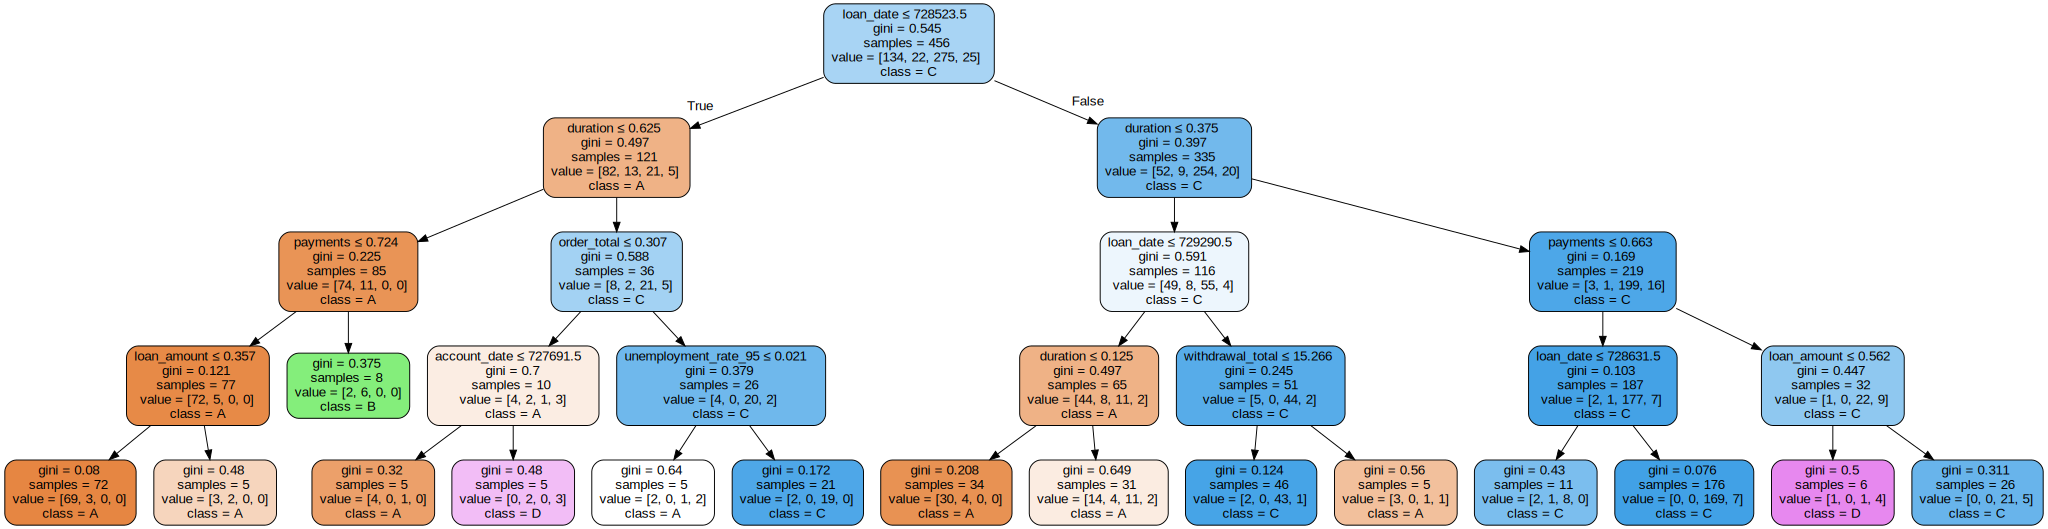

In [17]:
class_names = ['A', 'B', 'C', 'D']

dot_data = tree.export_graphviz(dt_stump, out_file=None, 
                      feature_names=np.array(combined_num.columns),  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True) 

graph = graphviz.Source(dot_data)  
graph

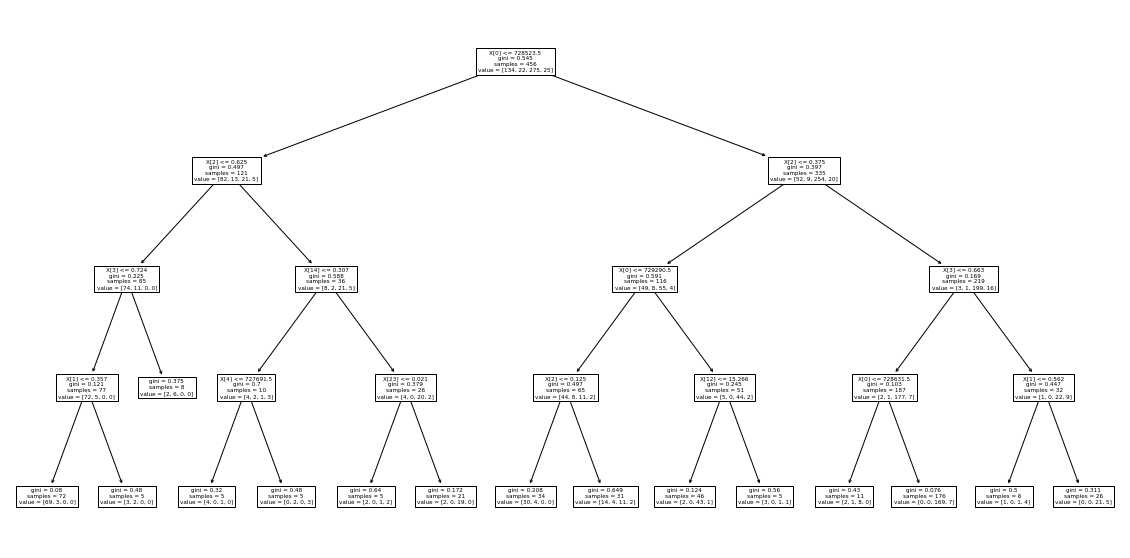

In [18]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(dt_stump)
plt.show()

This creates a classifier that provides us a general idea of the importance.  However, we note that there is a lot of reliance on the date of account/loan openings, which is not particularly enforceable for future decision making (especially loan opening.  We also see that it favors Class A and C accounts (which are completed loans and those in good standing), which makes sense as most of their risk taking will provide 'good' loans in the first place.  Therefore, we will drop the date columns (loan and account) and rerun a decision tree.  We will retain owner birth as we can judge by age once we know when the data was taken (assuming it's legal)

Of note, there is only one identifier that uses the district information (specifically, number of committed crimes), and it seems to simply split between Class C (currently active loans in good standing), and class A (completed active loans).

Notes that we can garner for loans to reject for future purposes though:
 - Short duration new loans with high payments are likely to not be paid (2 completed fully paid, 6 did not)
 - Old accounts, with few orders are likely to be in debt on long duration loans (only 5 samples, 3 in debt)
 - May be not relevant (as it applies to loans opened long befre), but longer duration loans with a low payment, and low amount are likely to remain in debt (whereas loans for more than the arbitrary value 0.562 represents were more likely to be in good standing).
 
Obviously, these are not had and fast rules as there are more than a few mididentifications using this, but it can give some ideas to future loan brokers.

In [19]:
combined_num2 = combined_num.drop(['loan_date', 'account_date'], axis = 1)

In [20]:
hparams = Hparams()
x_train, x_test, y_train, y_test = train_test_split(
    combined_num2, target, test_size=0.33, random_state=42
)
dt_stump = DecisionTreeClassifier(
    max_depth=hparams.max_depth, 
    min_samples_leaf=hparams.min_samples_leaf
)

dt_stump.fit(x_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(x_test, y_test)

In [21]:
print(f'Accuracy rate is {dt_stump.score(x_test, y_test)}')

Accuracy rate is 0.7477876106194691


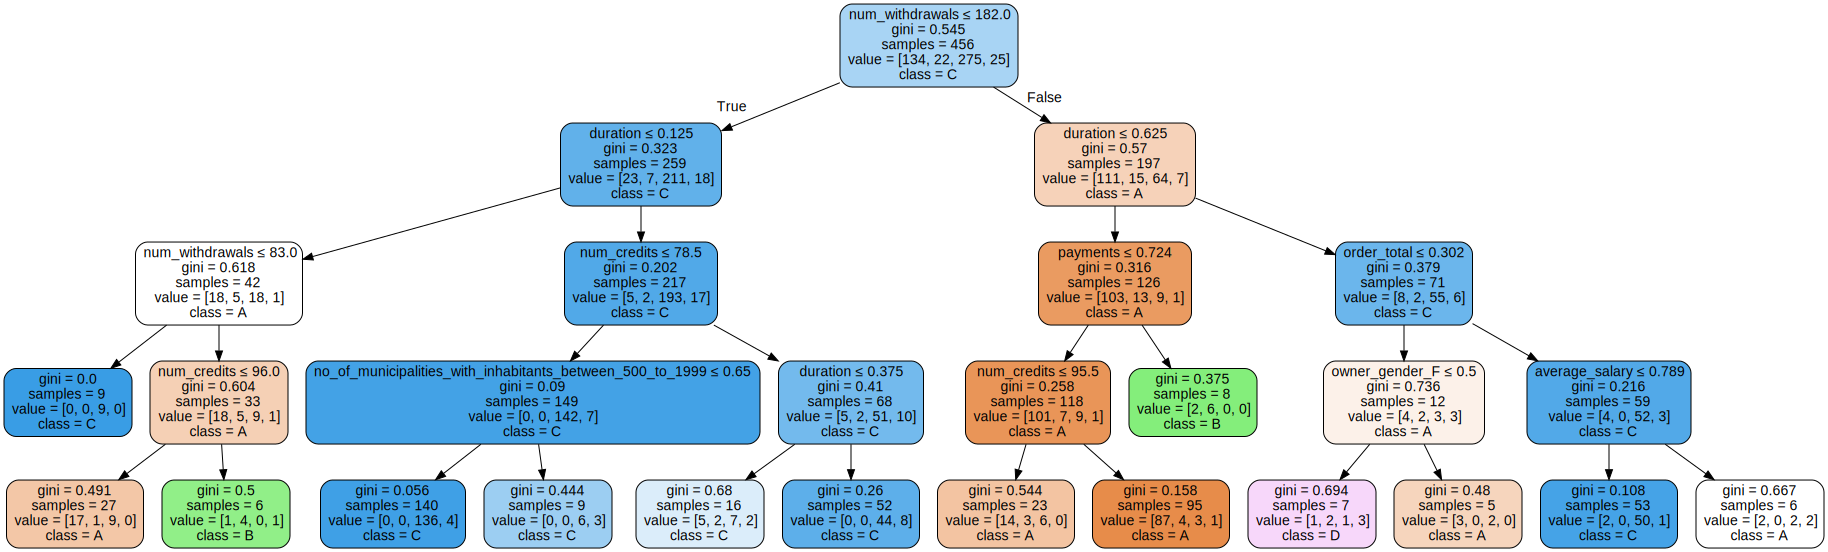

In [22]:
class_names = ['A', 'B', 'C', 'D']

dot_data = tree.export_graphviz(dt_stump, out_file=None, 
                      feature_names=np.array(combined_num2.columns),  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True) 

graph = graphviz.Source(dot_data)  
graph

This seems to give us a bit more insight into our data that is enforceable from a loan manager's perspective (though is slightly less accurate when applied to the test set), it first splits the cases into the number of withdrawals, where the vast majoirty of low withdrawal accounts product favorable loans, with a very odd exeption of withdrawlwas with a very low number of withdrawals and a high number of credits looking for a short duration loan.

For the high withdrawal accounts, we can see most are favorable again, though with a couple more exceptions of short duration accounts with high payments, and males with a low number of orders look for a long duration loan.  We can also see some of the marketing team's impact by noting that it is much more likely to have currently active loans from Prague.

This looks to be a more usefull decision tree so we will use it for our data exploration.  Below we use Gridsearch CV to find the 'best' hyperparamters.

In [27]:
parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf' : [1,3,5,7,9]
    
}

In [29]:
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = parameters)

In [30]:
clf.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 3, 5, 7, 9]})

In [31]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1}

Using GridSearch CV, the training set shows the best parameters using a criterion of entropy, a max depth of 2 and no limit to the minimum number of samples.  We run these criterion below on the entire training set (please note the testing set was not used in determinign thoes parameters)

In [33]:
dt_ideal = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth=2 ,
    min_samples_leaf=1
)

dt_ideal.fit(x_train, y_train)
dt_ideal_err = 1.0 - dt_ideal.score(x_test, y_test)

In [34]:
print(f'Accuracy rate is {dt_ideal.score(x_test, y_test)}')

Accuracy rate is 0.7566371681415929


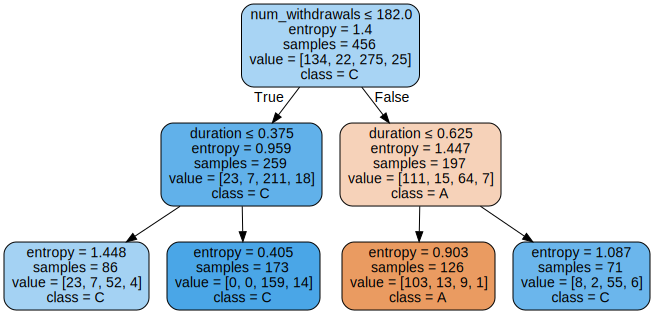

In [35]:
dot_data = tree.export_graphviz(dt_ideal, out_file=None, 
                      feature_names=np.array(combined_num2.columns),  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True) 

graph = graphviz.Source(dot_data)  
graph

We'll note that is provides a better accuracy score, however a less than useful graph.  Due to the already in-place loan programs, all of values are either in Class 'A' or Class 'C' which provide us with 'good' loans.  This really seems to give us mostly an identifier of whether ot not a loan will still be active or totally paid off.  We'll also note that number of withdrawals and the duration of the loan are the only two classifiers used (which may very well be a very simplistic classifer for deciding if a loan is 'low' or 'high' risk, though the fact it does not include the amount or length may be a red flag as to the usefulness.